## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')


from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Get sub-sampling

60


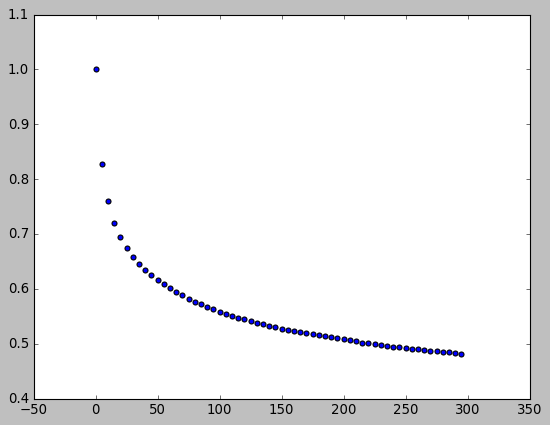

In [18]:
filename = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/sub_sampling_analysis/na_auto_MI_per_lag_6.npy'

sub_sampling = np.load(filename)
step = 5
shifts = step*np.arange(sub_sampling.shape[0])
plt.scatter(shifts, sub_sampling/np.max(sub_sampling))

auto_mi = 0.6*np.max(sub_sampling)
time_lag = np.where(np.isclose(sub_sampling, auto_mi, rtol=1e-02, atol=1e-02))
print(shifts[time_lag[0][0]])

# STORE EXPLAINED VARIANCES
explained_var = []

## Load Data - Create Dataset

In [22]:
# loading entire high-dimensional trajectory
expm = 'normal'
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + expm + '/'
trajectories = os.listdir(path)

lengths = []
sub_sampling = 60
n_markers = 20
for n, traj_n in enumerate(trajectories):
    if traj_n != ".ipynb_checkpoints":
        path_n = path + traj_n + '/trajectories_na/'
        trajs = os.listdir(path_n)
        trajectory = loadmat(path_n + trajs[0])
        trajectory = trajectory['trajectory']
        
        all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]))
        composite_dataset = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]+n_markers))
        
        for i, time_bin in enumerate(trajs):
            if time_bin != 'behavs':
                trajectory = loadmat(path_n + time_bin)
                trajectory = trajectory['trajectory'] 
                idx = np.round(np.linspace(0, trajectory.shape[0]-1, int(trajectory.shape[0]/sub_sampling))).astype(int)
                
                displacement = np.zeros()
                for marker in range(n_markers):
                    
                displacement = [np.mean(np.absolute(trajectory[i: i+1]), axis=0) for i in idx]
                displacement = np.asarray(displacement)
                displacement = displacement/sub_sampling
                print(displacement.shape, trajectory.shape)
                trajectory = trajectory[idx]
                idx_2 = i*trajectory.shape[0]
                all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory
                composite_traj = np.concatenate((trajectory, displacement), axis=1)
                composite_dataset[idx_2:idx_2+trajectory.shape[0], 0:composite_dataset.shape[1]] = composite_traj

                
        all_trajectories = np.nan_to_num(all_trajectories)
        lengths.append(all_trajectories.shape[0])

        if n==0:
            rats = all_trajectories
            rats_enhanced = composite_dataset
        if n>0:
            rats = np.concatenate((rats, all_trajectories), axis=0)
            rats_enhanced = np.concatenate((rats_enhanced, composite_dataset), axis=0)


print(rats.shape)

nan_cols = []
for i in range(rats.shape[1]):
    if np.isnan(rats[:, i]).any():
        rats = np.nan_to_num(rats)
        cnt = np.count_nonzero(np.isnan(rats[:, i]))
        nan_cols.append(cnt)


(1800, 60) (108000, 60)


ValueError: could not broadcast input array from shape (1800,120) into shape (1800,80)

## Dimensionality Reduction - PCA

Explained variance 3 PCs: 0.8267119779926262


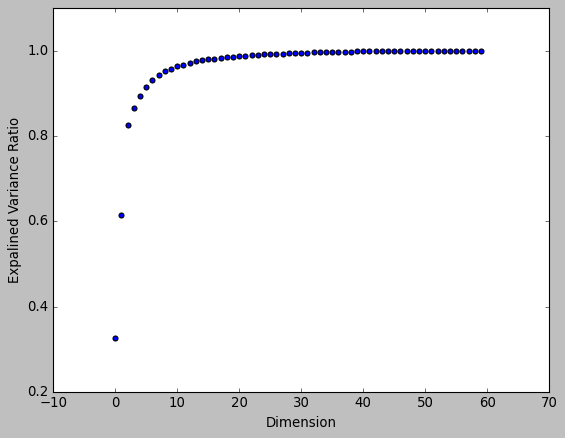

[[ 6.50890392e-01  4.86887794e-14 -2.04019873e-15]
 [ 4.86887794e-14  5.72167560e-01  1.55472552e-16]
 [-2.04019873e-15  1.55472552e-16  4.19776569e-01]]
Explained variance 3 PCs: 0.7476289153600066


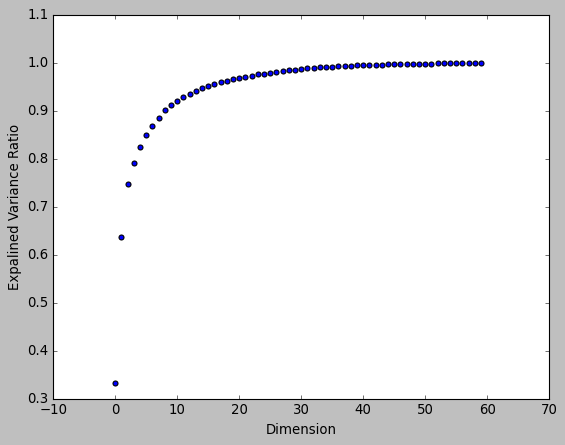

[[ 6.59457715e-01 -7.40504711e-14  1.56697566e-14]
 [-7.40504711e-14  6.01357582e-01  2.00611622e-14]
 [ 1.56697566e-14  2.00611622e-14  2.17889507e-01]]
Explained variance 3 PCs: 0.8474072529503889


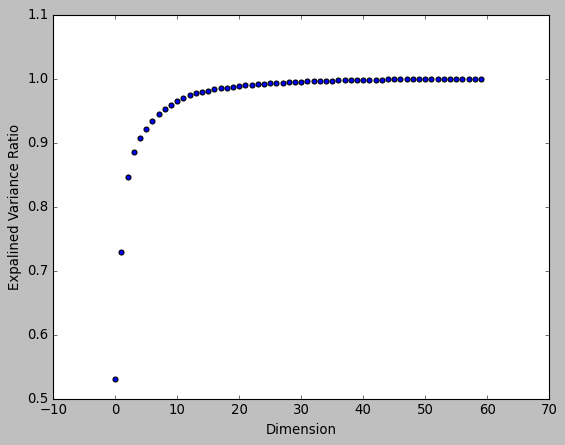

[[1.04600888e+00 1.30148869e-14 1.38476844e-15]
 [1.30148869e-14 3.87407905e-01 2.04851833e-15]
 [1.38476844e-15 2.04851833e-15 2.33014784e-01]]
Explained variance 3 PCs: 0.9069138986088964


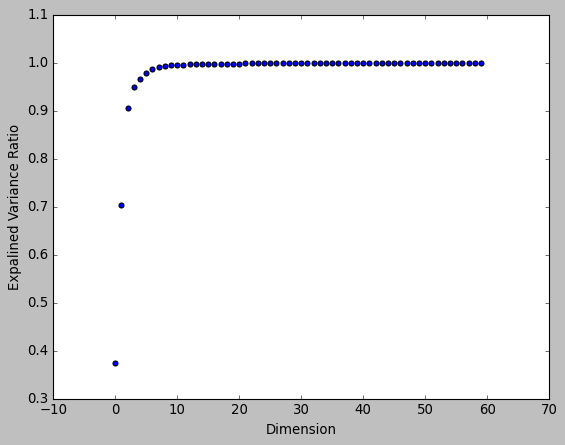

[[ 7.37085133e-01  4.22402224e-14 -1.04835072e-14]
 [ 4.22402224e-14  6.47559130e-01  7.75738575e-16]
 [-1.04835072e-14  7.75738575e-16  3.99573534e-01]]


In [6]:
for i, length in enumerate(lengths):
    # inspecting inter-dimensional variance with PCA
    if i == 0:
        idx = 0
    else:
        idx += lengths[i-1]

    traj = rats[idx:idx+length, :]

    pca = PCA()
    pca.fit(traj)
    
    # STORE EXPLAINED VARIANCE
    explained_var.append(pca.explained_variance_ratio_)
    explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
    print('Explained variance 3 PCs:', sum(pca.explained_variance_ratio_[0:3]))

    plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
    plt.ylabel('Expalined Variance Ratio')
    plt.xlabel('Dimension')
    plt.show()
    
    # reduce data according to explained variance values using linear PCA
    pca = PCA(n_components=3)
    reduced_traj = pca.fit_transform(traj)
    reduced_traj.shape

    print(np.cov(np.transpose(reduced_traj)))

## Dimensionality Reduction - Drug

In [7]:
expm = 'drug'
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + expm + '/'
trajectories = os.listdir(path)
print(trajectories)

lengths = []
# nan_cols = [12,13,14]
sub_sampling = 60;
for n, traj_n in enumerate(trajectories):
    if traj_n != ".ipynb_checkpoints":
        path_n = path + traj_n + '/trajectories_na/'
        trajs = os.listdir(path_n)
        trajectory = loadmat(path_n + trajs[0])
        trajectory = trajectory['trajectory']
        # all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]-len(nan_cols)))
        all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]))
        for i, time_bin in enumerate(trajs):
            if time_bin != 'behavs':
                trajectory = loadmat(path_n + time_bin)
                trajectory = trajectory['trajectory'] 
                # trajectory = np.delete(trajectory, nan_cols, 1)
                idx = np.round(np.linspace(0, trajectory.shape[0] - 1, sub_sampling)).astype(int)
                trajectory = trajectory[idx]
                idx_2 = i*trajectory.shape[0]
                all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory

        lengths.append(all_trajectories.shape[0])

        if n==0:
            rats = all_trajectories
        if n>0:
            rats = np.concatenate((rats, all_trajectories), axis=0)

print(rats.shape)

['traj_5', 'traj_8', 'traj_3', 'traj_4', 'traj_7', 'traj_2', 'traj_6', 'traj_1']
(423000, 60)


In [8]:
nan_cols = []
for i in range(rats.shape[1]):
    if np.isnan(rats[:, i]).any():
        rats = np.nan_to_num(rats)
        cnt = np.count_nonzero(np.isnan(rats[:, i]))
        nan_cols.append(cnt)

print(nan_cols)

[0]


Explained variance 3 PCs: 0.8650886239700754


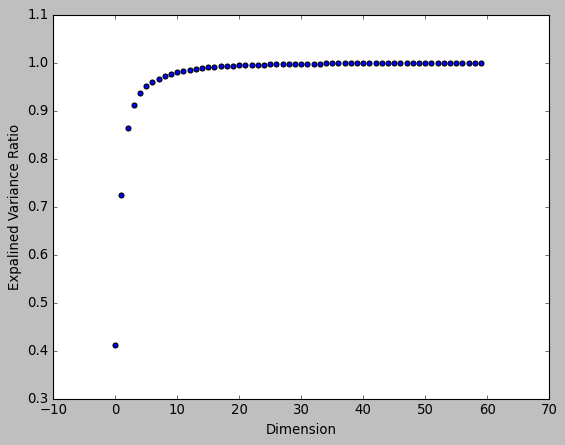

[[ 7.93502291e-01  2.59381459e-15  1.45264786e-14]
 [ 2.59381459e-15  6.01181911e-01 -1.13922961e-14]
 [ 1.45264786e-14 -1.13922961e-14  2.67846799e-01]]
Explained variance 3 PCs: 0.8844123528154164


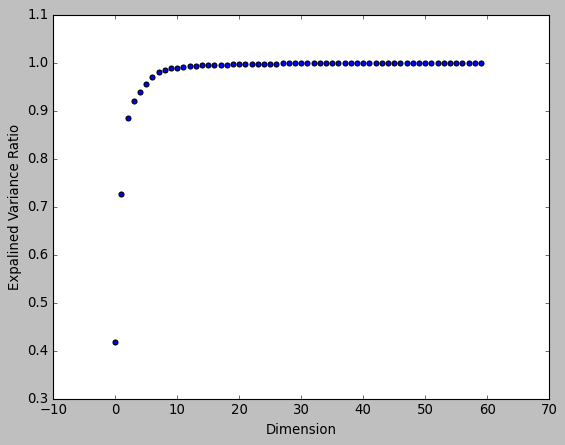

[[ 8.10649150e-01  3.95553767e-14 -7.25400025e-15]
 [ 3.95553767e-14  6.00192460e-01 -8.75201251e-15]
 [-7.25400025e-15 -8.75201251e-15  3.02848858e-01]]
Explained variance 3 PCs: 0.7703614776225719


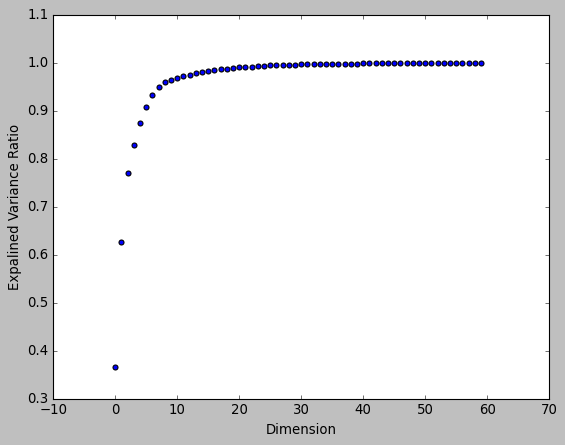

[[ 7.15522112e-01 -8.37401620e-15  3.36724423e-15]
 [-8.37401620e-15  5.05772156e-01 -1.24916735e-14]
 [ 3.36724423e-15 -1.24916735e-14  2.79023301e-01]]
Explained variance 3 PCs: 0.8295284904523152


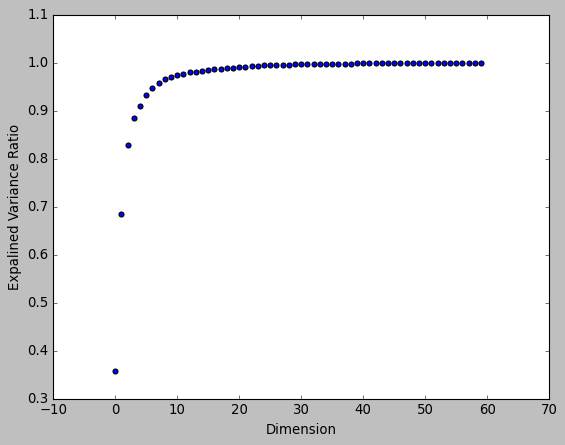

[[ 6.96910110e-01 -3.91367365e-15  3.78470803e-15]
 [-3.91367365e-15  6.33992086e-01 -7.09062472e-16]
 [ 3.78470803e-15 -7.09062472e-16  2.81113446e-01]]
Explained variance 3 PCs: 0.9059762399040041


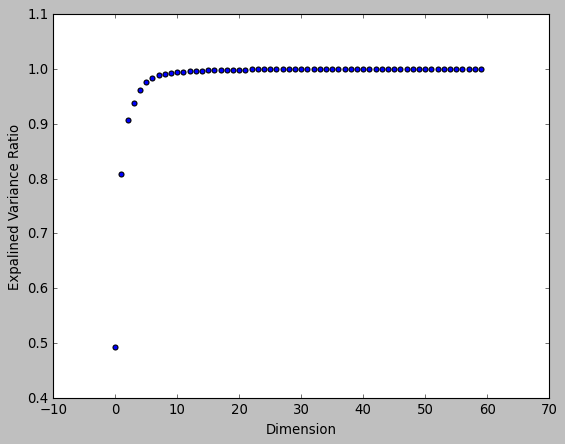

[[ 9.47861286e-01  1.14761328e-14 -6.09842493e-15]
 [ 1.14761328e-14  6.05043211e-01  1.30892629e-14]
 [-6.09842493e-15  1.30892629e-14  1.86266481e-01]]
Explained variance 3 PCs: 0.8520193938389856


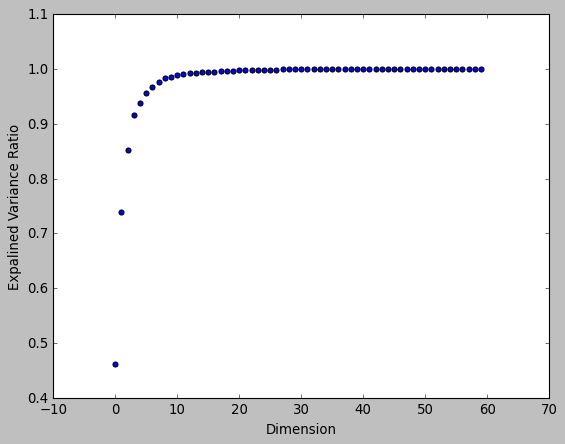

[[ 8.76826241e-01  1.43498597e-14 -3.11442522e-14]
 [ 1.43498597e-14  5.26198582e-01  1.59691229e-14]
 [-3.11442522e-14  1.59691229e-14  2.13422743e-01]]
Explained variance 3 PCs: 0.8793702815384603


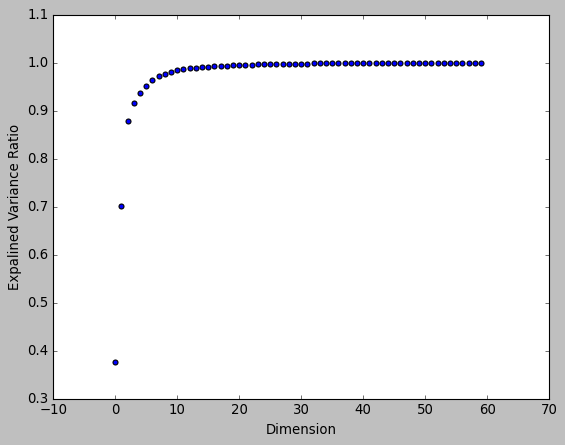

[[ 7.15532838e-01 -4.66423842e-14  6.39180832e-16]
 [-4.66423842e-14  6.18637691e-01  3.37478149e-15]
 [ 6.39180832e-16  3.37478149e-15  3.37875747e-01]]
Explained variance 3 PCs: 0.8831290033022858


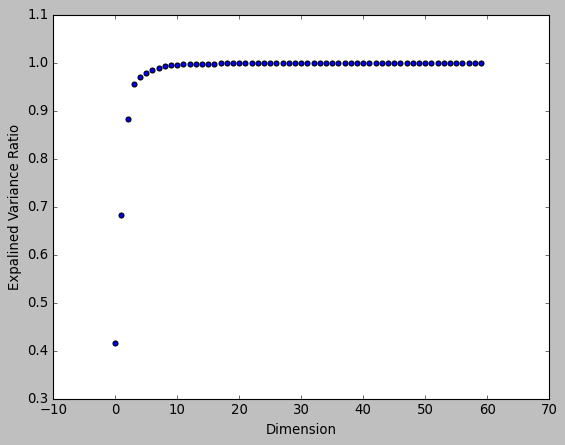

[[ 8.16124662e-01  9.26960187e-15 -4.19524585e-14]
 [ 9.26960187e-15  5.21817823e-01  3.89493415e-15]
 [-4.19524585e-14  3.89493415e-15  3.89247377e-01]]


In [9]:
for i, length in enumerate(lengths):
    # inspecting inter-dimensional variance with PCA
    if i == 0:
        idx = 0
    else:
        idx += lengths[i-1]

    traj = rats[idx:idx+length, :]

    pca = PCA()
    pca.fit(traj)
    
    # STORE EXPLAINED VARIANCE    
    explained_var.append(pca.explained_variance_ratio_)
    explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]

    plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
    print('Explained variance 3 PCs:', sum(pca.explained_variance_ratio_[0:3]))
    plt.ylabel('Expalined Variance Ratio')
    plt.xlabel('Dimension')
    plt.show()

    # reduce data according to explained variance values using linear PCA
    pca = PCA(n_components=3)
    reduced_traj = pca.fit_transform(traj)
    reduced_traj.shape

    print(np.cov(np.transpose(reduced_traj)))

## Dimensionality Reduction - Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

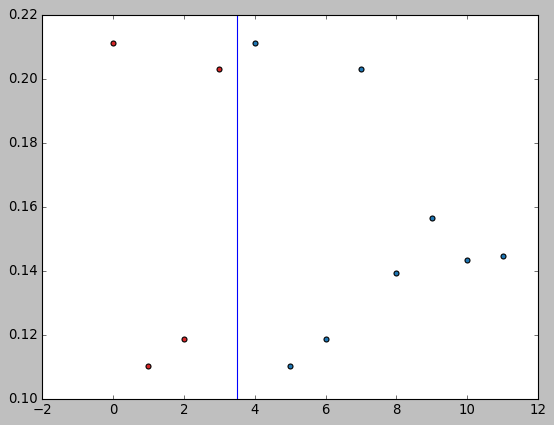

In [11]:
how_many = [4, 8]
PC1 = []
PC2 = []
PC3 = []
for i in range(len(explained_var)):
    PC1.append(explained_var[i][0])
    PC2.append(explained_var[i][1])
    PC3.append(explained_var[i][2])
    
plt.scatter(np.arange(how_many[0]), PC3[0:4], c='#d62728')
plt.scatter(np.arange(how_many[0], how_many[0] + how_many[1]), PC3[4:12], c='#1f77b4')
plt.axvline(x=3.5)
plt.show
